# Library Imports

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [812]:
import s3fs
import scipy.stats
import time
import multiprocessing as mp
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.stats as astv
import seaborn as sns
import ast
import glob
import json
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import torch
import torch.nn as nn

In [24]:
%matplotlib inline

# Functions to read and preprocess raw data from Open Data Hub

In [732]:
'''
Removing parallelized versions. This is purely experimental
'''

def get_raw_data(fs, path, debug=False):
    '''Reads raw data from S3 - not parallelized
    '''
    data = {}
    
    gestures_paths = fs.ls(path)
    
    for gesture in gestures_paths:
        files_to_read = fs.ls(gesture)
    
        key = gesture.split('/')[-1] 
        data[key] = []
        if debug:
            print(key)
    
        for file in files_to_read:
            with fs.open(file) as f:
                content = json.loads(f.read())
            data[key].append(content)
    
    return data

counter = 0
def process_crosses_data(data_crosses_raw):
    '''Returns list of size N_samples and each element = tuple(index, label, acc+rot vel dataframe, rot angle dataframe)
    '''

    global counter
    
    data_cross_list = []
    gesture = 'draw-cross'

    for d in data_crosses: #loop over each sample
        acc_data = pd.DataFrame([x['acceleration'] for elem in data_crosses[d] for x in elem['motion']])
        acc_data.columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']

        rot_data = pd.DataFrame([x['rotationRate'] for elem in data_crosses[d] for x in elem['motion']])
        rot_data.columns = ['rotation_alpha', 'rotation_beta', 'rotation_gamma']

        timestamp_data = pd.DataFrame([x['timestamp'] for elem in data_crosses[d] for x in elem['motion']])
        timestamp_data.columns = ['timestamp']

        motion_df = pd.concat([acc_data, rot_data, timestamp_data], axis=1).sort_values('timestamp', ascending=True).drop('timestamp', axis=1)
        orientation_df = None

        data_cross_list.append((counter, gesture, motion_df, orientation_df))
        counter += 1
        
    return data_cross_list

def process_dance_data(data_dance_raw):
    '''Returns list of size N_samples and each element = tuple(index, label, acc+rot vel dataframe, rot angle dataframe)
    '''

    #Ugly
    #convert appropriate data to dataframes
    global counter
    
    data = []
    #counter = 0 #counter from before
    for k in data_dance_raw.keys(): #loop over each dance type
        d = data_dance_raw[k]
        for example in d: #loop over each sample
            gesture = example['gesture']

            motion = np.array(example['motion'])
            orientation = np.array(example['orientation'])

            #process motion data
            if len(motion)>0:
                if motion.shape[1]==7: #incl. acc and rotational velocities
                    motion_df = pd.DataFrame(motion, columns=['acceleration_x', 'acceleration_y', 'acceleration_z',
                                                             'rotation_alpha', 'rotation_beta', 'rotation_gamma',
                                                              'timestamp'
                                                             ])\
                                    .sort_values('timestamp', ascending=True)\
                                    .drop('timestamp', axis=1)
                
                elif motion.shape[1]==4: #incl. acc only
                    motion_df = pd.DataFrame(motion, columns=['acceleration_x', 'acceleration_y', 'acceleration_z',
                                                              'timestamp'
                                                             ])\
                                    .sort_values('timestamp', ascending=True)\
                                    .drop('timestamp', axis=1)

                else: #shouldn't enter
                    motion_df = pd.DataFrame()
            else: #no motion data recorded
                motion_df = pd.DataFrame()


            #process orientation data
            if len(orientation) > 0:
                orientation_df = pd.DataFrame(orientation, columns=['alpha', 'beta', 'gamma', 'timestamp'])\
                                        .sort_values('timestamp', ascending=True)\
                                        .drop('timestamp', axis=1)
            else:
                orientation_df = pd.DataFrame()

            data.append((counter, gesture, motion_df, orientation_df))

            counter += 1
    
    return data

### read raw dance and crosses data

In [725]:
#S3 filesystem
fs = s3fs.S3FileSystem(key=os.environ['AWSACCESSKEYID'], secret=os.environ['AWSSECRETACCESSKEY'])

In [726]:
path_to_dance_data = 'cchase-rh-demo-4/training-data'
path_to_cross_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-26'

In [727]:
#parallelize
data_dance_raw   = get_raw_data(fs, path_to_dance_data, debug=False)
data_cross_raw = get_raw_data(fs, path_to_cross_data, debug=False)

In [736]:
data_cross_raw = data_crosses_raw

### preprocess dance and crosses data

In [737]:
counter = 0
data_dance_proc = process_dance_data(data_dance_raw)
data_cross_proc = process_crosses_data(data_cross_raw)

In [738]:
print(f'Last  counter in dance: {data_dance_proc[-1][0]}')
print(f'First counter in crosses: {data_cross_proc[0][0]}')

Last  counter in dance: 852
First counter in crosses: 853


### general notes and data structures

In [688]:
#orientation: 845 total, 839 with non-empty dfs
#motion: 845 total, 748 with non-empty dfs and 7 columns

pd.DataFrame(data_new['floss'][10]['motion']).describe()
pd.DataFrame(data_new['floss'][10]['orientation']).describe()

#orientation - euler angles
#motion: cols 0-2 -> linear acc
#motion: cols 3-5 -> rotational velocities

,0,1,2,3
count,310.000000,310.000000,310.000000,3.100000e+02
mean,125.605938,-20.924327,-25.599517,1.552657e+12
std,89.796931,76.789315,61.482467,1.513799e+03
min,0.292870,-177.140740,-89.928350,1.552657e+12
25%,71.210148,-67.698563,-74.131070,1.552657e+12
50%,100.303605,-31.494230,-55.364030,1.552657e+12
75%,142.042400,19.477432,11.850713,1.552657e+12
max,359.844680,179.842390,89.688450,1.552657e+12


In [746]:
print(data_dance_proc[11][0])
print(data_dance_proc[11][1])
print(data_dance_proc[11][2].head())
print(data_dance_proc[11][3].head())

11
draw-circle
   acceleration_x  acceleration_y  acceleration_z
0        -3.40591         1.73555         1.59486
1        -2.91173         1.83084         1.36433
2        -2.55274         1.97981         0.89712
3        -2.22280         1.85264         0.68485
4        -1.31190         1.53318         0.43874
       alpha      beta     gamma
0  270.20182  82.41354  68.08590
1  273.32958  82.47885  65.35138
2  277.10278  82.40938  62.11125
3  281.37906  82.29850  58.53968
4  287.09173  82.02338  53.94220


In [749]:
print(data_cross_proc[11][0])
print(data_cross_proc[11][1])
print(data_cross_proc[11][2].head())
print(data_cross_proc[11][3]) #no orientation data for crosses

864
draw-cross
   acceleration_x  acceleration_y  acceleration_z  rotation_alpha  \
0        0.437621       -0.361197        0.218245       27.146408   
1       -0.061869       -0.021413        0.571339       20.676787   
2       -0.009421       -0.448732        0.711852       11.854978   
3       -0.315024       -0.016403        0.688548        0.687941   
4       -0.454791       -0.021163        0.285032      -13.664064   

   rotation_beta  rotation_gamma  
0     -20.553412      -19.960574  
1     -16.340551      -48.567160  
2      -4.659583      -60.690602  
3       5.523492      -57.651537  
4     -10.383155      -38.102528  
None


ensure rotational vel for crosses and dance moves are in similar range

they were collected on different days and in different formats

In [754]:
dance_check = pd.concat([d[2] for d in data_dance_proc], axis=0)
cross_check = pd.concat([d[2] for d in data_cross_proc], axis=0)

/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [757]:
dance_check.describe()

,acceleration_x,acceleration_y,acceleration_z,rotation_alpha,rotation_beta,rotation_gamma
count,269868.000000,269868.000000,269868.000000,250203.000000,250203.000000,250203.000000
mean,-0.730870,2.457877,0.362534,6.871613,-13.091080,0.327086
std,11.193316,10.298969,10.439231,201.657267,277.630430,195.045713
min,-85.313580,-67.500120,-79.381690,-1609.774830,-1976.330430,-1779.898450
25%,-5.456895,-2.461088,-3.786112,-85.683750,-111.204370,-91.917525
50%,-0.174145,1.006175,0.201645,3.016210,-5.293670,-0.592950
75%,4.256060,7.215428,4.484542,104.403755,86.146325,84.021500
max,77.125810,75.981230,77.263130,1991.135000,1911.954200,1733.608780


In [758]:
cross_check.describe()

,acceleration_x,acceleration_y,acceleration_z,rotation_alpha,rotation_beta,rotation_gamma
count,38615.000000,38615.000000,38615.000000,38615.000000,38615.000000,38615.000000
mean,-0.808515,2.375926,-0.725004,5.699723,1.428731,1.659132
std,6.907364,8.242594,5.619517,146.679524,122.667549,194.635223
min,-69.957815,-57.276299,-65.892320,-1151.539404,-1081.784704,-1488.653936
25%,-1.766049,-0.734528,-2.282298,-37.789671,-43.763129,-58.377132
50%,-0.066188,0.228248,-0.047940,4.964082,1.831111,-2.803892
75%,1.222144,4.616980,1.258357,57.736094,48.898419,35.856791
max,44.626137,83.359574,40.536364,811.671650,1383.510223,1564.324892


above rotation_* distributions have relatively similar values -> confident looking at same measurement across two datasets

contrast with angle (only for dance) below

In [759]:
dance_orientation_check = pd.concat([d[3] for d in data_dance_proc], axis=0)

In [760]:
dance_orientation_check.describe()

,alpha,beta,gamma
count,261384.000000,261384.000000,261384.000000
mean,183.683485,41.744668,0.748673
std,119.372116,96.079878,49.551119
min,0.000000,-179.999180,-89.997150
25%,68.184188,4.453968,-39.453632
50%,192.628335,58.713680,-0.258050
75%,295.968240,114.049278,41.548920
max,359.999790,179.998910,89.998060


alpha varies from 0 degrees to 360 degrees (0 to $2\pi$)

beta varies from -180 degrees to 180 degrees (-$\pi$ to $\pi$)

gamma varies from -90 degrees to 90 degrees (-$\frac{\pi}{2}$ to $\frac{\pi}{2}$)

# Work only with 7-column motion df

In [831]:
data = data_dance_proc + data_cross_proc

In [832]:
print(len(data))
print(len(data_dance_proc))
print(len(data_cross_proc))

1038
853
185


In [833]:
data = [d for d in data if d[2].shape[1]==6 and d[2].shape[0]>50] #at least have 50 measurements

In [834]:
print(len(data))

937


In [835]:
np.unique([d[1] for d in data], return_counts=True)

(array(['draw-circle', 'draw-cross', 'draw-triangle', 'fever', 'floss',
        'roll', 'shake'], dtype='<U13'),
 array([121, 185, 128, 122, 110, 135, 136]))

In [836]:
def featurize(ts, bins, TAG):
    '''Take time-series and create features
    '''
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b = np.histogram(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {f'{TAG}_mean_over_median': 0, #dimensionless            
                    f'{TAG}_std_over_median': 0, #dimensionless            
                    f'{TAG}_length': length,
                    f'{TAG}_kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {f'{TAG}_mean_over_median': mean/median, #dimensionless            
            f'{TAG}_std_over_median': std/median, #dimensionless            
            f'{TAG}_length': length,
            f'{TAG}_kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'{TAG}_binfrac_{i}'] = val
        
    
    return features

def normalize(ts):
    '''Linearly scale time-series to have values between 0-1
    '''
    minimum = np.min(ts)
    ts_shifted = ts - minimum #set min -> 0
    
    maximum = np.max(ts_shifted)
    ts_scaled = ts_shifted / maximum #in [0,1]
    
    return ts_scaled

def magnitude(df, cols):
    '''magnitude of vector
    '''
    return np.sqrt((df[cols]**2).sum(axis=1))

def find_bins(ts_list, method='freedman'):
    ''' Find bin edges for histograms based on different methods
    '''
    
    ts_all = np.concatenate(ts_list)
    
    plt.clf()
    if method in ['freedman', 'scott', 'knuth', 'blocks']:
        n,b = astv.histogram(ts_all, bins=method)
        plt.hist(ts_all, bins=b)
    else:
        n,b,p = plt.hist(ts_all)
    
    return ts_all, b

### bin finding - each col individually

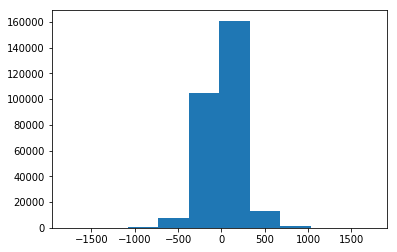

In [837]:
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
       'rotation_alpha', 'rotation_beta', 'rotation_gamma']
method = 'plt'

col_bins = {}

for col in cols:
    ts_all, b = find_bins([d[2][col] for d in data], method=method)
    col_bins[col] = b

### featurize - each col individually

In [838]:
#don't worry about layout etc.
df_list = []
for col in cols:
    index_list, feature_list, label_list = [], [], []
    for d in data:
        features = featurize(d[2][col], bins=col_bins[col], TAG=col.upper())
        
        feature_list.append(features)
        index_list.append(d[0])
        label_list.append(d[1])
    
    feature_col_df = pd.DataFrame(feature_list)
    
    df_list.append(feature_col_df)

In [839]:
df = pd.concat(df_list, axis=1)
df['index'] = index_list
df['label'] = label_list

In [840]:
df.iloc[0]

ACCELERATION_X_binfrac_0                     0
ACCELERATION_X_binfrac_1                     0
ACCELERATION_X_binfrac_2                     0
ACCELERATION_X_binfrac_3                     0
ACCELERATION_X_binfrac_4               0.22884
ACCELERATION_X_binfrac_5              0.761755
ACCELERATION_X_binfrac_6            0.00940439
ACCELERATION_X_binfrac_7                     0
ACCELERATION_X_binfrac_8                     0
ACCELERATION_X_binfrac_9                     0
ACCELERATION_X_kurtosis               0.184926
ACCELERATION_X_length                      319
ACCELERATION_X_mean_over_median        3.48315
ACCELERATION_X_std_over_median        -27.2695
ACCELERATION_Y_binfrac_0                     0
ACCELERATION_Y_binfrac_1                     0
ACCELERATION_Y_binfrac_2                     0
ACCELERATION_Y_binfrac_3                     0
ACCELERATION_Y_binfrac_4              0.990596
ACCELERATION_Y_binfrac_5            0.00940439
ACCELERATION_Y_binfrac_6                     0
ACCELERATION_

In [841]:
df.shape

(937, 86)

### bin finding - magnitudes only (ignore)

In [774]:
#data preparation
acc_cols = ['acceleration_x', 'acceleration_y', 'acceleration_z']
rot_cols = ['rotation_alpha', 'rotation_beta', 'rotation_gamma']

data_mag = []
for d in data:
    df1 = magnitude(d[2], acc_cols)
    df1 = pd.DataFrame(df1, columns=['acc'])
    
    df2 = magnitude(d[2], rot_cols)
    df2 = pd.DataFrame(df2, columns=['rot'])
    
    df = pd.concat([df1, df2], axis=1)

    data_mag.append((d[0], d[1], df))

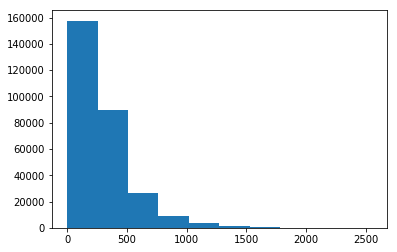

In [775]:
cols = ['acc', 'rot']
method = 'plt'

mag_bins = {}

for col in cols:
    ts_all, b = find_bins([d[2][col] for d in data_mag], method=method)
    mag_bins[col] = b

### featurize - acceleration magnitude and rotation velocity magnitude (ignore)

In [776]:
#don't worry about layout etc.
df_list = []
for col in cols:
    index_list, feature_list, label_list = [], [], []
    for d in data_mag:
        features = featurize(d[2][col], bins=mag_bins[col], TAG=col.upper())
        
        feature_list.append(features)
        index_list.append(d[0])
        label_list.append(d[1])
    
    feature_col_df = pd.DataFrame(feature_list)    
    df_list.append(feature_col_df)

In [777]:
df = pd.concat(df_list, axis=1)
df['index'] = index_list
df['label'] = label_list

In [780]:
df.iloc[500]

ACC_binfrac_0           0.0487805
ACC_binfrac_1           0.0731707
ACC_binfrac_2            0.195122
ACC_binfrac_3            0.457317
ACC_binfrac_4            0.198171
ACC_binfrac_5            0.027439
ACC_binfrac_6                   0
ACC_binfrac_7                   0
ACC_binfrac_8                   0
ACC_binfrac_9                   0
ACC_kurtosis             0.556337
ACC_length                    328
ACC_mean_over_median     0.957393
ACC_std_over_median      0.307257
ROT_binfrac_0            0.213415
ROT_binfrac_1            0.786585
ROT_binfrac_2                   0
ROT_binfrac_3                   0
ROT_binfrac_4                   0
ROT_binfrac_5                   0
ROT_binfrac_6                   0
ROT_binfrac_7                   0
ROT_binfrac_8                   0
ROT_binfrac_9                   0
ROT_kurtosis              1.03287
ROT_length                    328
ROT_mean_over_median     0.963845
ROT_std_over_median      0.288681
index                         580
label         

In [781]:
df.shape

(937, 30)

### filter labels

In [842]:
df = df[~df['label'].isin(['draw-triangle'])]
df['label'].value_counts()

draw-cross     185
shake          136
roll           135
fever          122
draw-circle    121
floss          110
Name: label, dtype: int64

### model - individual cols

In [843]:
np.random.seed(0)

train_df, test_df = train_test_split(df, train_size=0.70)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (566, 86)
test size = (243, 86)
draw-cross     130
shake          103
fever           90
draw-circle     84
roll            82
floss           77
Name: label, dtype: int64
draw-cross     55
roll           53
draw-circle    37
shake          33
floss          33
fever          32
Name: label, dtype: int64


/home/sanjay/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [844]:
model = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=10, min_samples_leaf=3)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_labels = train_df['label']
train_pred = model.predict(train_df.drop('label', axis=1))
train_pred_prob = model.predict_proba(train_df.drop('label', axis=1))

test_labels = test_df['label']
test_pred = model.predict(test_df.drop('label', axis=1))
test_pred_prob = model.predict_proba(test_df.drop('label', axis=1))

### model validation

In [845]:
def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot()

    labels = np.sort(list(train_labels.value_counts().index))

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(confusion)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

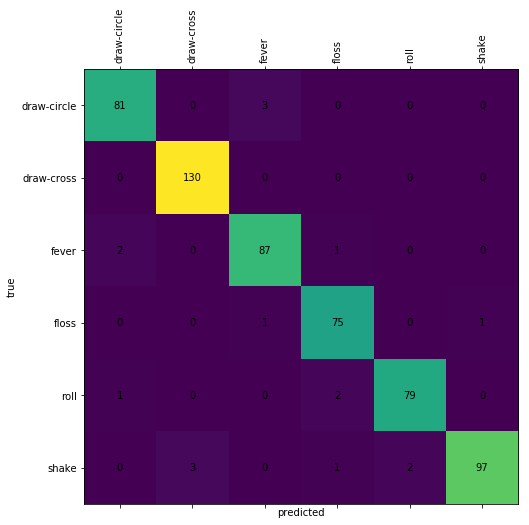

In [846]:
_ = plot_confusion_matrix(train_labels, train_pred)

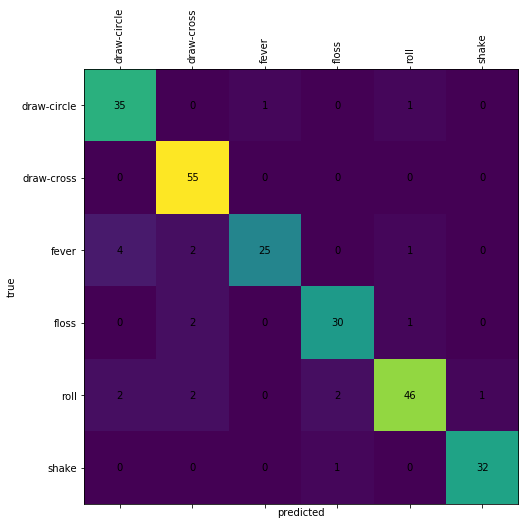

In [847]:
_ = plot_confusion_matrix(test_labels, test_pred)

#### multiclass AUC

In [848]:
n_class_list = model.classes_
n_class = model.n_classes_

def calc_roc_metrics(df, pred_prob):
    fpr, tpr, thresholds, auc = {}, {}, {}, {}

    for n in range(n_class):
        label = n_class_list[n]
        class_labels = (df['label']==label).astype(int)

        class_pred_prob = pred_prob[:, n]

        fpr[label], tpr[label], thresholds[label] = roc_curve(class_labels, class_pred_prob)
        auc[label] = roc_auc_score(class_labels, class_pred_prob)
        
    return fpr, tpr, thresholds, auc

def calc_precision_recall_metrics(df, pred_prob):
    precision, recall, thresholds = {}, {}, {}
    
    for n in range(n_class):
        label = n_class_list[n]
        class_labels = (df['label']==label).astype(int)

        class_pred_prob = pred_prob[:, n]

        precision[label], recall[label], thresholds[label] = precision_recall_curve(class_labels, class_pred_prob)
        
    return precision, recall, thresholds
    
def plot_multiclass_auc(fpr_dict, tpr_dict, auc_dict):
    fig = plt.figure(figsize=(9,9))

    for n in fpr_dict:
        fpr = fpr_dict[n]
        tpr = tpr_dict[n]
        auc = auc_dict[n]

        plt.plot(fpr, tpr, label=f'AUC f({n}) = {auc:.3f}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    
def plot_multiclass_pr(precision_dict, recall_dict):
    fig = plt.figure(figsize=(9,9))

    for n in precision_dict:
        precision = precision_dict[n]
        recall = recall_dict[n]
        
        plt.plot(recall, precision, label=n)
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()    
    
def calculate_multiclass_auc(df, auc_dict):
    macro_auc = np.mean(list(auc_dict.values())) #unweighted
    print(f'Macro AUC = {macro_auc}')

    micro_auc = 0 #weighted by % of values in each class
    total = 0
    counts = df['label'].value_counts()
    
    for n in auc_dict:
        micro_auc += counts.loc[n] * auc_dict[n]
        total += counts.loc[n]
    micro_auc /= total
    print(f'Micro AUC = {micro_auc}')
    
    return macro_auc, micro_auc

In [849]:
train_fpr, train_tpr, train_thresholds, train_auc = calc_roc_metrics(train_df, train_pred_prob)
test_fpr, test_tpr, test_thresholds, test_auc = calc_roc_metrics(test_df, test_pred_prob)

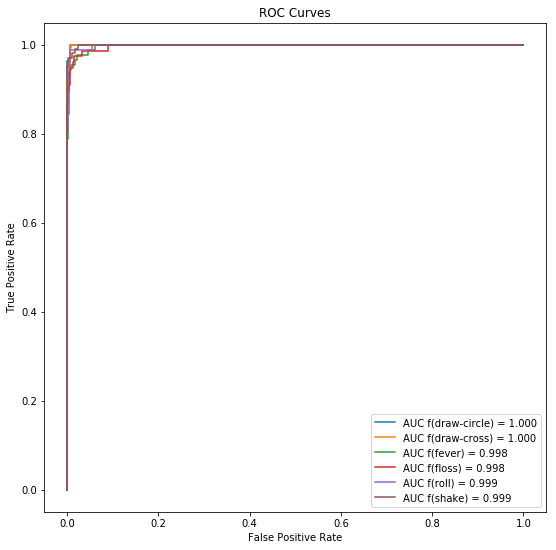

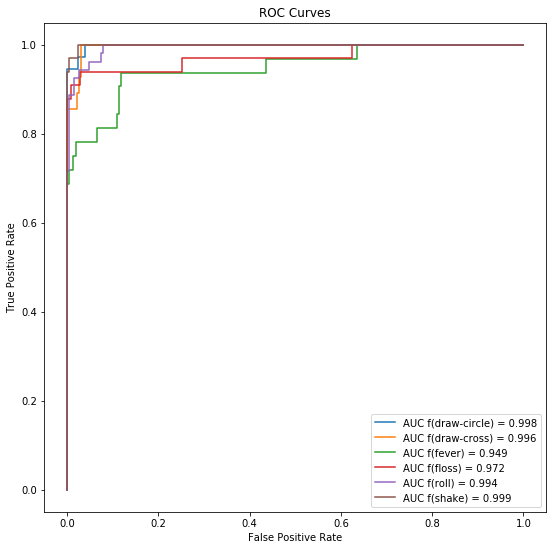

In [850]:
plot_multiclass_auc(train_fpr, train_tpr, train_auc)
plot_multiclass_auc(test_fpr, test_tpr, test_auc)

In [851]:
_ = calculate_multiclass_auc(train_df, train_auc)
_ = calculate_multiclass_auc(test_df, test_auc)

Macro AUC = 0.9988190757050105
Micro AUC = 0.9989018695109194
Macro AUC = 0.984825589545013
Micro AUC = 0.9869754604701974


### run next 3 cells with appropriate chosen_label to choose threshold for appropriate balance between true positive rate and false positive rate

In [852]:
chosen_label = 'floss'

train_chooser = pd.DataFrame({'Threshold': train_thresholds[chosen_label], 'True Positive Rate': train_tpr[chosen_label], 'False Positive Rate': train_fpr[chosen_label]})
test_chooser = pd.DataFrame({'Threshold': test_thresholds[chosen_label], 'True Positive Rate': test_tpr[chosen_label], 'False Positive Rate': test_fpr[chosen_label]})

In [853]:
#formatting
train_chooser['True Positive Rate'] = train_chooser['True Positive Rate'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
train_chooser['False Positive Rate'] = train_chooser['False Positive Rate'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
train_chooser['Threshold'] = train_chooser['Threshold'].map('{:,.2f}'.format)

test_chooser['True Positive Rate'] = test_chooser['True Positive Rate'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
test_chooser['False Positive Rate'] = test_chooser['False Positive Rate'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
test_chooser['Threshold'] = test_chooser['Threshold'].map('{:,.2f}'.format)

In [854]:
#tpr = tp / (tp + fn = condition positive) same as recall
#fpr = fp / (tn + fn = condition negative)
test_chooser

,Threshold,True Positive Rate,False Positive Rate
0,1.51,0.00%,0.00%
1,0.51,3.03%,0.00%
2,0.28,87.88%,0.00%
3,0.27,87.88%,0.95%
4,0.27,90.91%,0.95%
5,0.25,90.91%,2.86%
6,0.25,93.94%,2.86%
7,0.17,93.94%,25.24%
8,0.17,96.97%,25.24%
9,0.08,96.97%,62.38%


### precision-recall curves and thresholds

In [855]:
train_precision, train_recall, train_pr_thresholds = calc_precision_recall_metrics(train_df, train_pred_prob)
test_precision, test_recall, test_pr_thresholds = calc_precision_recall_metrics(test_df, test_pred_prob)

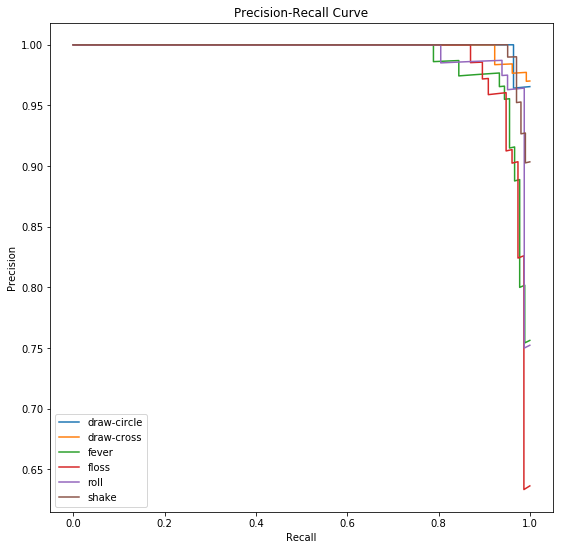

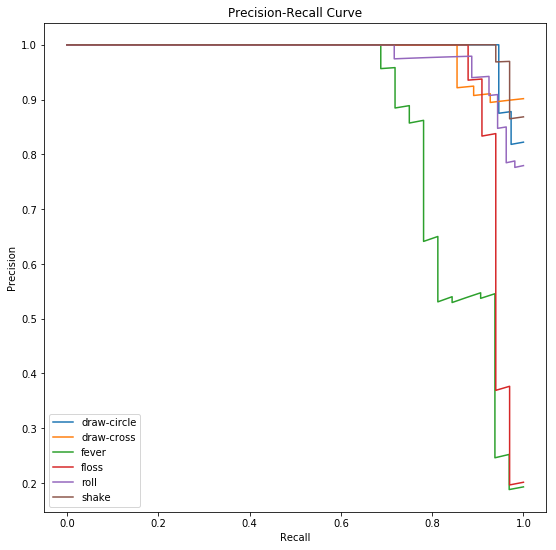

In [856]:
plot_multiclass_pr(train_precision, train_recall)
plot_multiclass_pr(test_precision, test_recall)

### run next 3 cells with appropriate chosen_label to choose threshold for appropriate balance between precision and recall

In [860]:
chosen_label = 'fever'

train_chooser = pd.DataFrame({'Threshold': train_pr_thresholds[chosen_label], 'Precision': train_precision[chosen_label][:-1], 'Recall': train_recall[chosen_label][:-1]})
test_chooser = pd.DataFrame({'Threshold': test_pr_thresholds[chosen_label], 'Precision': test_precision[chosen_label][:-1], 'Recall': test_recall[chosen_label][:-1]})

In [861]:
#formatting
train_chooser['Precision'] = train_chooser['Precision'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
train_chooser['Recall'] = train_chooser['Recall'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
train_chooser['Threshold'] = train_chooser['Threshold'].map('{:,.2f}'.format)

test_chooser['Precision'] = test_chooser['Precision'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
test_chooser['Recall'] = test_chooser['Recall'].apply(lambda x: 100*x).map('{:,.2f}%'.format)
test_chooser['Threshold'] = test_chooser['Threshold'].map('{:,.2f}'.format)

In [862]:
test_chooser

,Threshold,Precision,Recall
0,0.09,19.28%,100.00%
1,0.09,18.79%,96.88%
2,0.09,18.90%,96.88%
3,0.10,19.02%,96.88%
4,0.10,19.14%,96.88%
5,0.10,19.25%,96.88%
6,0.11,19.38%,96.88%
7,0.11,19.50%,96.88%
8,0.11,19.62%,96.88%
9,0.11,19.75%,96.88%


# END

# Ignore below

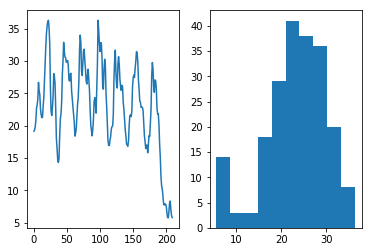

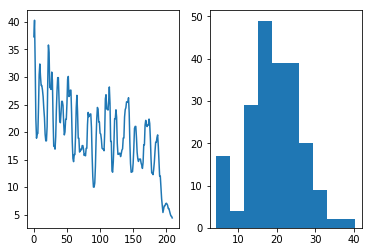

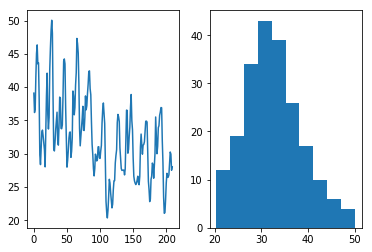

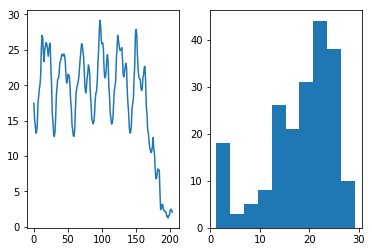

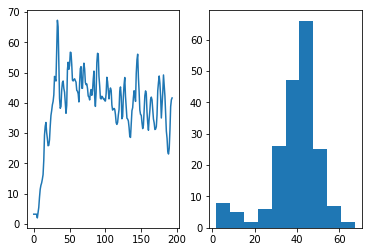

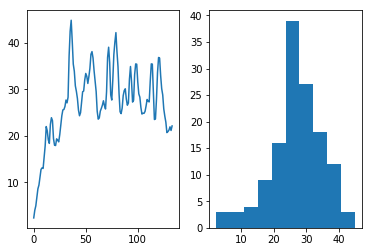

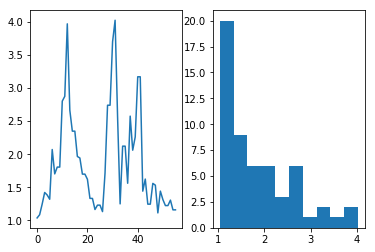

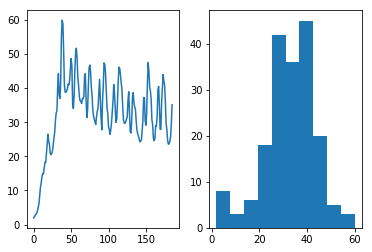

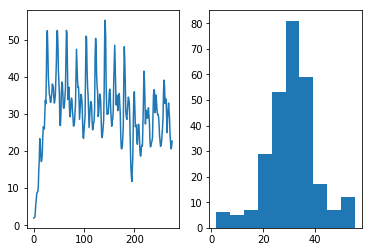

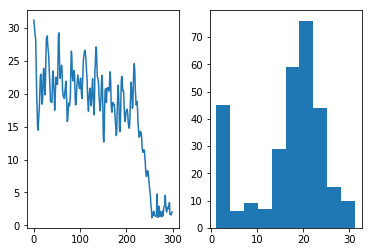

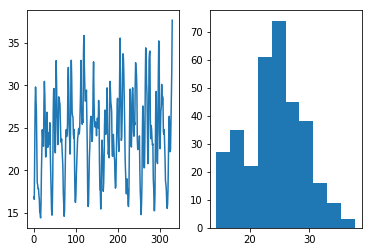

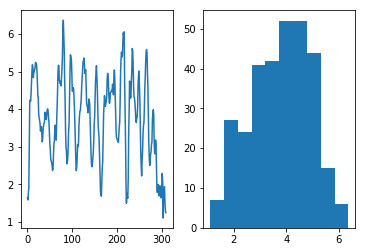

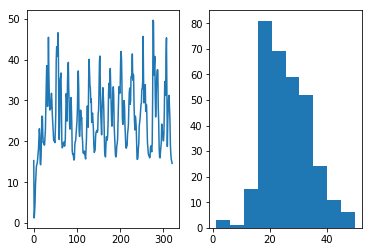

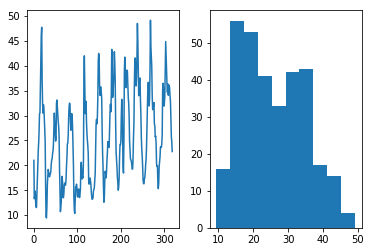

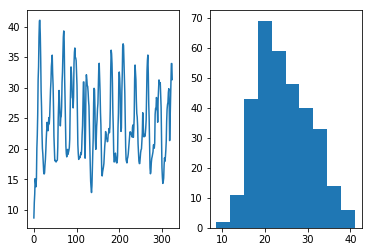

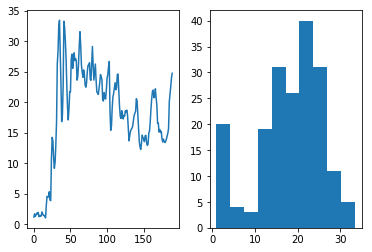

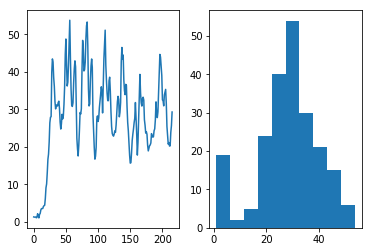

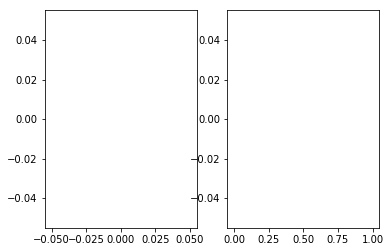

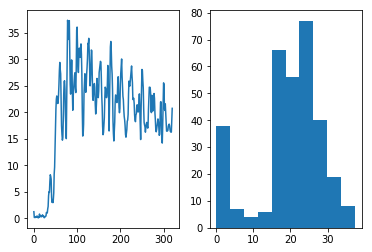

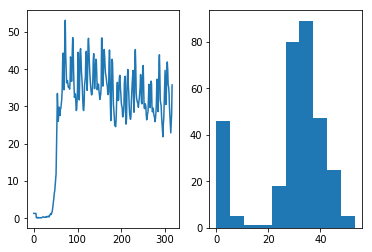

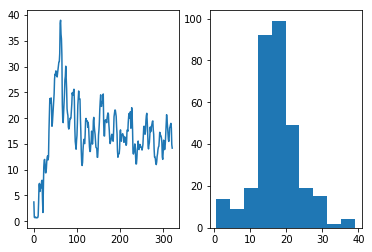

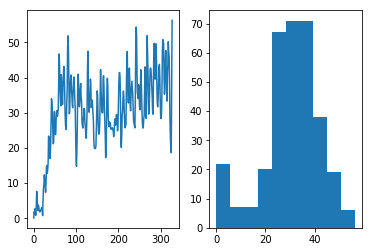

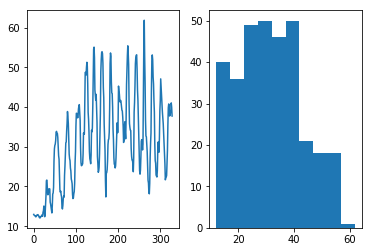

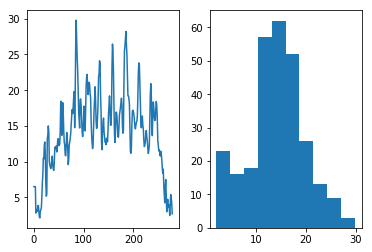

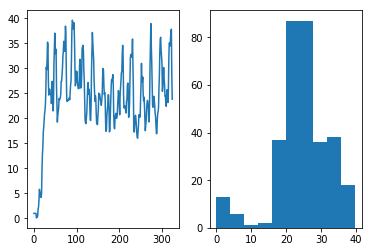

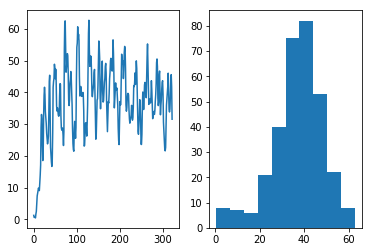

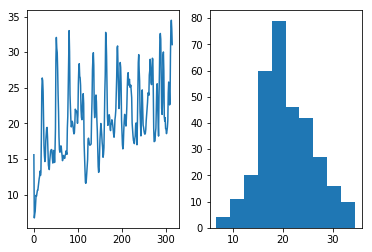

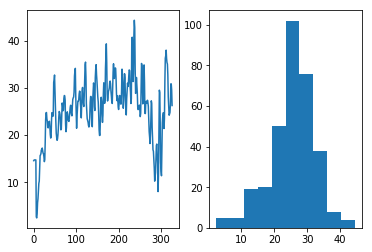

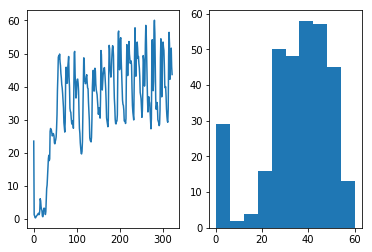

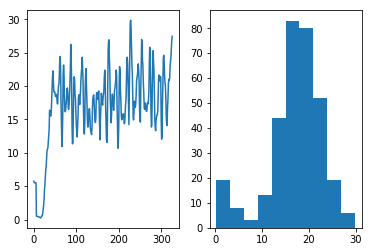

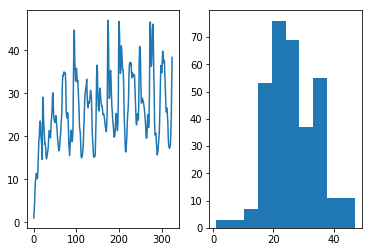

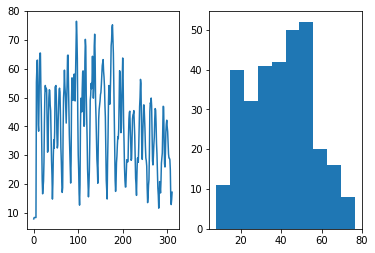

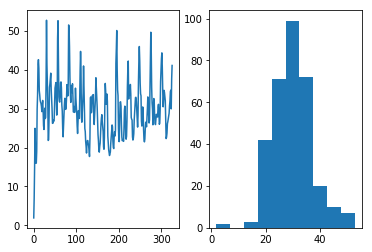

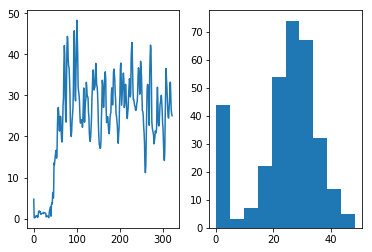

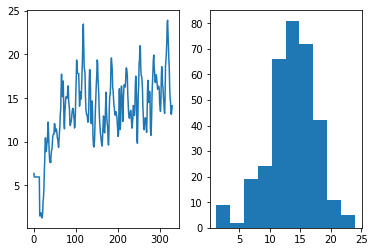

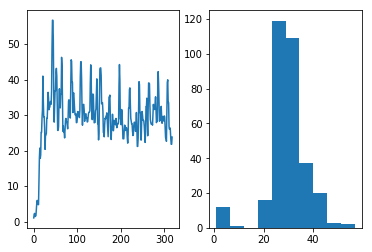

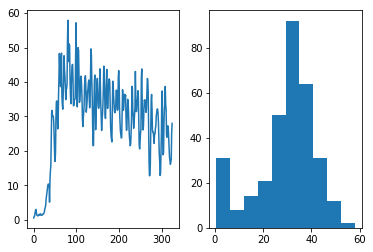

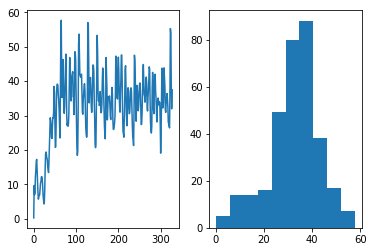

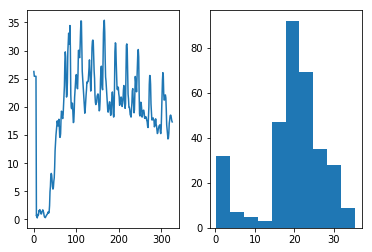

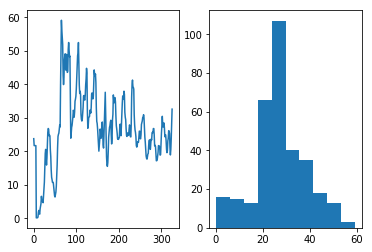

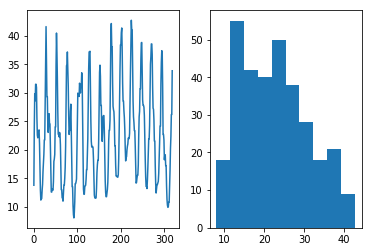

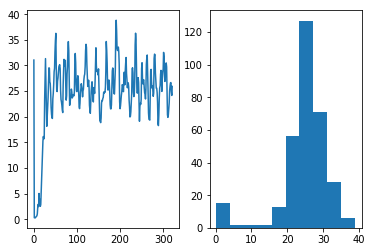

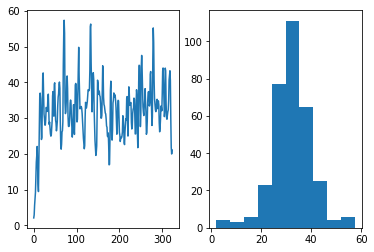

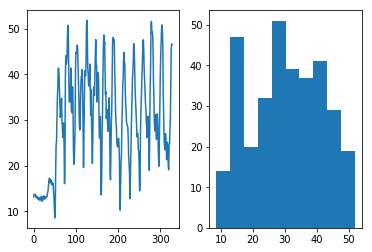

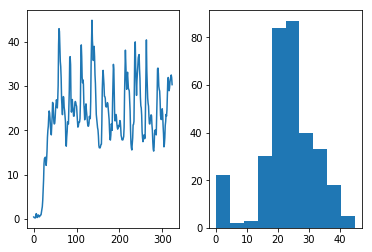

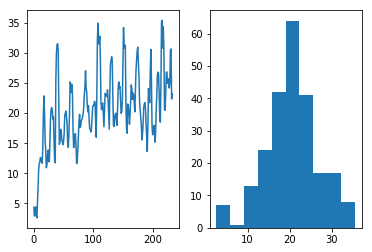

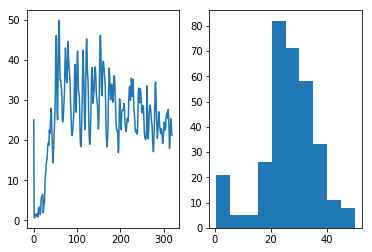

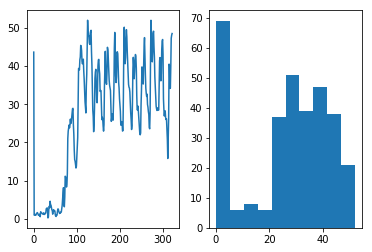

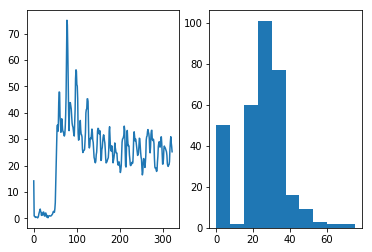

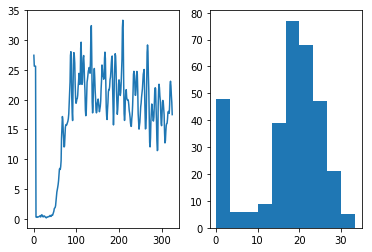

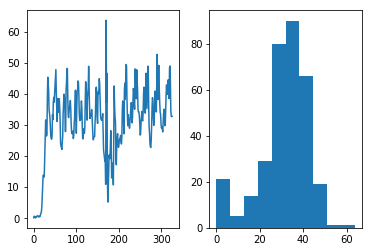

In [37]:
for counter, d in enumerate(data_mag['roll']):
    if counter > 50:
        break
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.plot(d)
    
    plt.subplot(1,2,2)
    plt.hist(d)

<IPython.core.display.Javascript object>


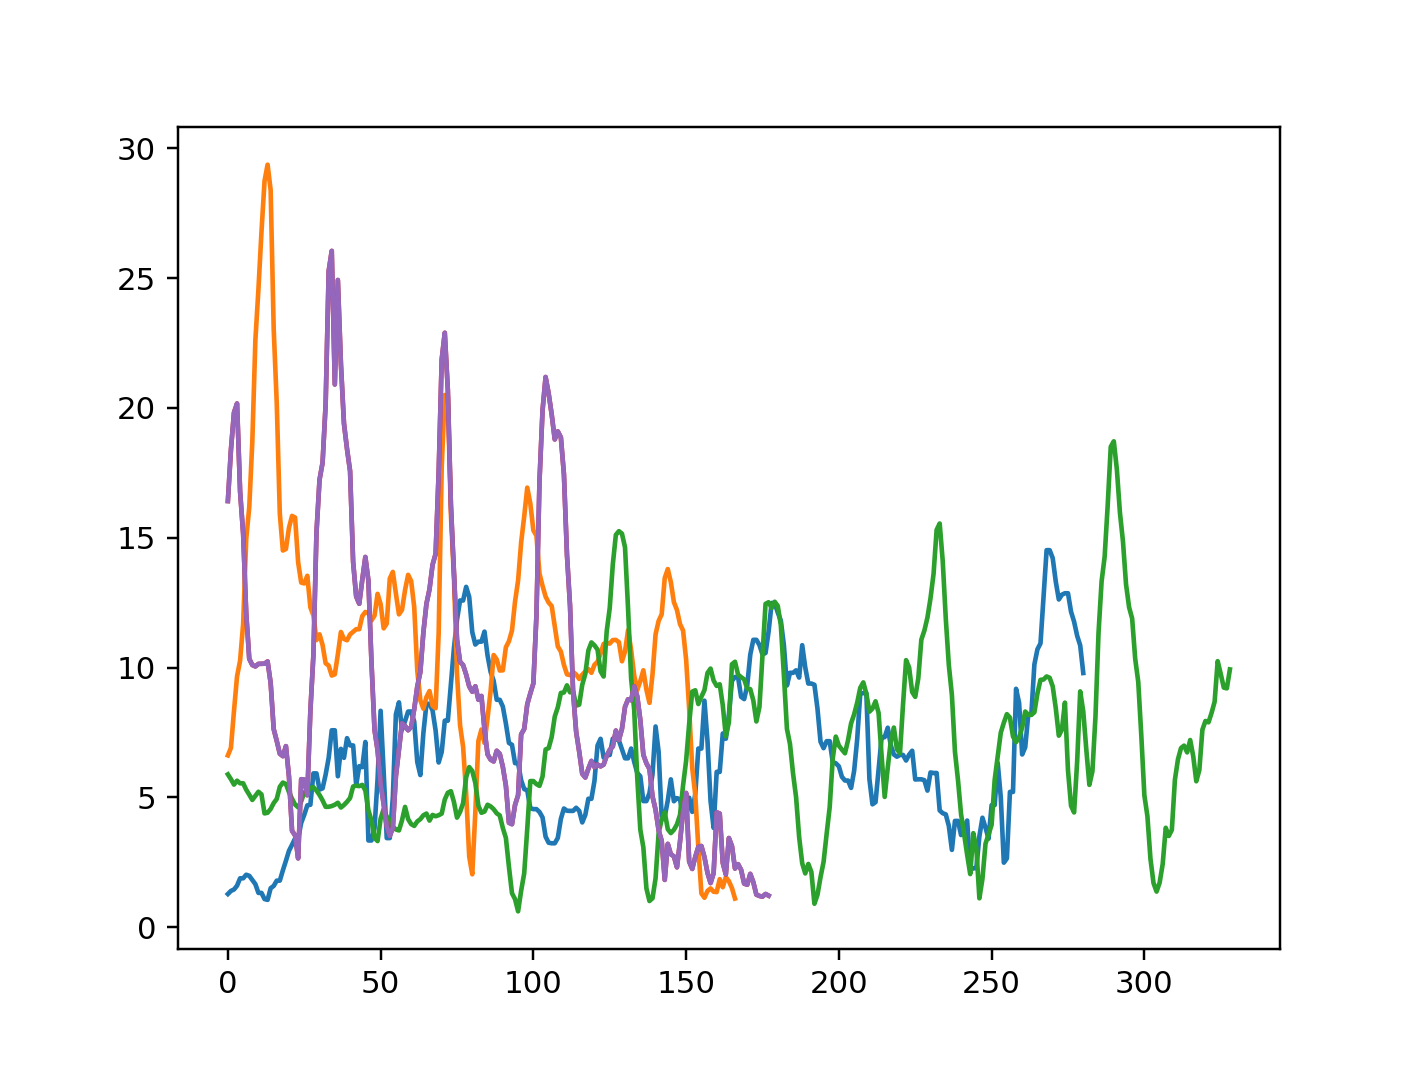

In [11]:
plt.figure()
plt.plot(acc_ts[15])
plt.plot(acc_ts[5])
plt.plot(acc_ts[20])

In [81]:
def normalize_ts(df_ts):
    acc = np.array(np.sqrt((df_ts**2).sum(axis=1)))
    
    acc_max = np.max(acc)
    
    acc = acc / acc_max
    
    return acc

def ratio_ts(df_ts):
    acc = df_ts[(df_ts[numer]!=0) & (df_ts[denom]!=0)]
    
    ratio = df_ts[numer] / df_ts[denom]
    
    return ratio

def deriv_ts(df_ts):
    third = np.array(np.sqrt((df_ts.diff()**2).sum(axis=1)))

    third_max = np.max(third)
    
    third = third / third_max
    
    return third
    
def featurize_ts(ts, bins=np.arange(0,1,0.1), tag='MAGNITUDE'):
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b = np.histogram(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {f'{tag}_mean_over_median': 0, #dimensionless            
                    f'{tag}_std_over_median': 0, #dimensionless            
                    f'{tag}_length': length,
                    f'{tag}_kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {f'{tag}_mean_over_median': mean/median, #dimensionless            
            f'{tag}_std_over_median': std/median, #dimensionless            
            f'{tag}_length': length,
            f'{tag}_kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'{tag}_binfrac_{i}'] = val
        
    return features
    
def create_df(data, transform_ts, tag, bins):
    features = []
    labels = []
    id_vals = []
    
    counter = 0
    for d in data: #loop over keys
        print(d)
        for elem in data[d]:            
            if elem.shape[0] > 5:
                features.append(featurize_ts(transform_ts(elem), bins=bins, tag=tag))
                labels.append(d)
                id_vals.append(counter)
                counter += 1
            
    features = pd.DataFrame(features)
    features['label'] = labels
    features['id'] = id_vals
    
    return features

def create_df_windows(data, transform_ts, tag, bins, window_size=50):
    features = []
    labels = []
    id_vals = []
    
    counter = 0
    for d in data: #loop over keys
        print(d)
        for elem in data[d]: #loop over every example
            if elem.shape[0] <= 5:
                continue
                
            N = len(elem)
            for segment_idx in np.arange(N-window_size):
                segment = elem[segment_idx:(segment_idx+window_size)]
                features.append(featurize_ts(transform_ts(segment), bins=bins, tag=tag))
                labels.append(d)
                id_vals.append(counter)
            counter += 1
                
    features = pd.DataFrame(features)
    features['label'] = labels
    features['id'] = id_vals
    
    return features

def create_cv_data(df, train_size=0.75, random_state=None):
    train_df, test_df = train_test_split(df, train_size=train_size, random_state=random_state)
    print(f'train size = {train_df.shape}')
    print(f'test size = {test_df.shape}')

    return train_df, test_df

def train_sklearn_model(model, train_df, test_df):
    #train model
    model.fit(train_df.drop('label', axis=1), train_df['label'])

    train_pred = model.predict(train_df.drop('label', axis=1))
    train_labels = train_df['label']
    train_acc = np.sum(train_pred==train_labels) / len(train_pred)

    test_pred = model.predict(test_df.drop('label', axis=1))
    test_labels = test_df['label']
    test_acc = np.sum(test_pred==test_labels) / len(test_pred)

    print(f'train acc = {train_acc}, test_acc = {test_acc}')
    
    return model

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    labels = list(train_labels.value_counts().index)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(confusion)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

In [195]:
featurize_ts(normalize_ts(data['floss'][50]))

{'MAGNITUDE_mean_over_median': 0.9920334946242951,
 'MAGNITUDE_std_over_median': 0.48920499295473124,
 'MAGNITUDE_length': 327,
 'MAGNITUDE_kurtosis': 0.510327677614264,
 'MAGNITUDE_binfrac_0': 0.10185185185185185,
 'MAGNITUDE_binfrac_1': 0.09567901234567901,
 'MAGNITUDE_binfrac_2': 0.09876543209876543,
 'MAGNITUDE_binfrac_3': 0.3117283950617284,
 'MAGNITUDE_binfrac_4': 0.19444444444444445,
 'MAGNITUDE_binfrac_5': 0.12037037037037036,
 'MAGNITUDE_binfrac_6': 0.04938271604938271,
 'MAGNITUDE_binfrac_7': 0.024691358024691357,
 'MAGNITUDE_binfrac_8': 0.0030864197530864196}

In [82]:
df_all = create_df(data, normalize_ts, 'MAGNITUDE', np.arange(0,1,0.1))

draw-circle
draw-triangle
fever
floss
roll


/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


shake


In [83]:
df_windows = create_df_windows(data, normalize_ts, 'MAGNITUDE', np.arange(0,1,0.1), window_size=50)

draw-circle
draw-triangle
fever
floss
roll
shake


In [58]:
df_all['label'].value_counts()

roll             134
shake            133
fever            118
draw-circle      117
draw-triangle    112
floss            109
Name: label, dtype: int64

In [57]:
df_windows['label'].value_counts()

roll             37458
shake            34459
fever            31475
draw-circle      31163
draw-triangle    30156
floss            28206
Name: label, dtype: int64

In [142]:
df1 = create_df(data, normalize_ts, 'MAGNITUDE', np.arange(0,1,0.1))

numer=0
denom=1
df2 = create_df(data, ratio_ts, 'RATIO_01', np.arange(0,20,5))

numer=0
denom=2
df3 = create_df(data, ratio_ts, 'RATIO_02', np.arange(0,20,5))

numer=1
denom=2
df4 = create_df(data, ratio_ts, 'RATIO_12', np.arange(0,20,5))

df5 = create_df(data, deriv_ts, 'DERIV', np.arange(0,1,0.1))

draw-circle
draw-triangle
fever
floss
roll


/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


shake
draw-circle
draw-triangle
fever
floss
roll
shake
draw-circle
draw-triangle
fever
floss
roll
shake
draw-circle
draw-triangle
fever
floss
roll
shake
draw-circle
draw-triangle
fever
floss
roll
shake


In [214]:
df = pd.concat([
                df1.drop(['id', 'label'], axis=1),
                df2.drop(['id', 'label'], axis=1), 
                df3.drop(['id', 'label'], axis=1), 
                df4.drop(['id', 'label'], axis=1), 
                df5
               ], 
               axis=1)